[-1.5164034  -0.48029894 -1.67332199 -0.20506274 -1.49843421  0.18599554
  0.04140941 -0.1195732  -1.05654836  0.69671166]
[-1.5164034  -0.48029894 -1.67332199 -0.20506274 -1.49843421  0.18599554
  0.04140941 -0.1195732  -1.05654836  0.69671166  9.        ]
0.8693229656973613
0.13761809961552057
2.0668428948950117
0.7813566729162241
0.2
('a', 1)
['adfkj']


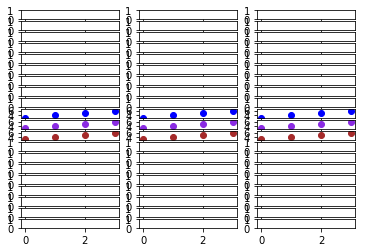

In [65]:
run statistic.ipynb

In [ ]:
run io.ipynb

[-0.70066861  0.87891008  0.7621223   0.38934398  0.43427889 -0.45570692
  0.17448826  0.12639754  1.49057353  1.42876762]
[-0.70066861  0.87891008  0.7621223   0.38934398  0.43427889 -0.45570692
  0.17448826  0.12639754  1.49057353  1.42876762  9.        ]
0.7770135757270271
0.022467457126848833
1.8597346523482503
0.6819807272194016
0.2
('a', 1)
['adfkj']


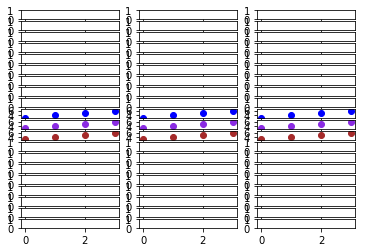

[0 1 0]


In [91]:
run data_anal.ipynb

In [ ]:
# Wrapper of ML kernals for hadron correlators on lattice
import sys
import os
import datetime
import numpy as np
import yaml as yl
import sklearn.ensemble as sle
import sklearn.tree as slt
import matplotlib.pyplot as plot
import math
from itertools import product

RandTrn = []
RandBC = []
RandUnl = []

noSaveRand = True

# Algorithm depend. params
TOL = 1.0e-4
MIN_SSPLIT = 2
# Minimum #fits
MIN_FIT = 1
# Minimum #training data
MIN_TRAIN = 10
# Minimum #bias correction (bc) data
MIN_BC = 10
# Minimum #unlabeled data
MIN_PREDICT = 10
PRINT = False
SHOW = True

# Class to ML fits 
#   pfile: parameter file
class ML_Regression:
    def __init__(self, pfile, RandTrn=[], RandBC=[], RandUnl=[]):
        params = yl.load(pfile)
        # model list: GradiantBoost, DecisionTree, RandomForest, DeepLearning(using Keras)
        self.mllist = ['GB', 'DT', 'RF', 'DL']
        # pick training data set: Jackknife, Bootstrap, Random
        self.tdlist = ['JK', 'BS', 'RM']
        #self.dfile = params['dfile']
        # method to pick training data set: default to pick first self.trn data
        self.nfit = MIN_FIT
        self.print = PRINT
        self.pre_anly = True
        self.fitter_DL = None
        try:
            self.pred = params['pred']
        except:
            self.pred = True
        try:
            self.tdset = params['tdset']
            if self.tdset in self.tdlist:
                try:
                    self.nfit = params['nfit']
                except:
                    self.nfit = MIN_FIT
                if self.tdset == 'JK':
                    # Jackknife index
                    try:
                        self.itdpar = params['tdpar']
                    except:
                        self.itdpar = 0
                    self.tdpar = self.itdpar-1
                    self.nfit = self.trn+1
                    self.jk = False
                if self.tdset == 'BS':
                    self.nfit += 1
                    self.bs = False
                    try:
                        self.fixbs = params['fixBS']
                    except:
                        self.fixbs = False
                    if self.fixbs: 
                        self.Rtrn = RandTrn
                        self.Rbc = RandBC
                        self.Runl = RandUnl
            elif not isinstance(self.tdset, int):
                print('Warning: Unknown training data subset identifier! Set to 0\n')
                self.tdset = 0
        except:
            self.tdset = 0
        try:
            self.odir = params['odir']
            self.osave = True
        except:
            self.osave = False
            self.ofile = None
        self.pdir = params['pdir']
        self.mlml = params['mlml']
        pdfile = open(self.pdir+'/'+self.mlml,'r')
        self.pf = yl.load(pdfile)
        pdfile.close()
        try:
            self.anal = params['analysis']
        except:
            self.anal = False
        if self.anal: 
            self.post_anal = ML_Analyze_PDF(params)
            self.save_tmpfits = True
            try:
                self.effmass = params['effmass']
            except:
                self.effmass = False
            try:
                self.ratio = params['ratio']
            except:
                self.ratio = False
        # list of Y momentum
        self.prY = params['momentum_Y']
        # list of Y z's
        self.zrY = params['z_Y']
        try:
            self.prX = params['momentum_X']
            if len(list(self.prX)) == 0:
                self.prX = None
        except:
            self.prX = None
        try:
            self.zrX = params['z_X']
            if len(list(self.zrX)) == 0:
                self.zrX = None
        except:
            self.zrX = None
        try:
            self.orY = params['operator_Y']
            if len(list(self.orY))==0:
                self.orY = [None]
        except:
            self.orY = [None]
        try:
            self.orX = params['operator_X']
            if len(list(self.orX))==0:
                self.orX = [None]
        except:
            self.orX = [None]
        try:
            self.srY = params['T_Y']
        except:
            self.srY = [None]
        try:
            self.srX = params['T_X']
        except:
            self.srX = [None]
        # list of Y time slices
        try:
            self.tr = params['ts_Y']
            if self.tr is None:
                self.tr = [None]
            elif len(list(self.tr)) == 0:
                self.tr = [None]
        except: 
            self.tr = [None]
        # list of X & Y time differences
        self.dtr = params['dts_X']
        # number of sources per configuration
        try:
            self.tfold = params['nsrc']
        except:
            self.tfold = 0
        self.ntrn = params['ntrn']
        if isinstance(self.ntrn, (int, str)):
            assert(int(self.ntrn) >= MIN_TRAIN)
            self.ntrn = [int(self.ntrn)]
        else:
            assert(len(self.ntrn) == len(self.prX))
        self.nbc = params['nbc']
        if isinstance(self.nbc, (int, str)):
            assert(int(self.nbc) >= MIN_BC)
            self.nbc = [int(self.nbc)]
        else:
            assert(len(self.nbc) == len(self.prX))
        # read in data stored in data pool 'database'
        # params[]: 
        #     format (data format, 'raw','pdf'); 
        #     binsize (data bin); 
        #     ddir (data files directory)
        #     dfile.x (X data filename); 
        #     dfile.y (Y data filename);
        self.database = Data_IO(params, self.tdset)
        self.data = None
        self.ndata = 0
        self.model = None
        self.fitnow = None
        self.isset = False
        self.errscale = None
        self.date = self.database.date #datetime.datetime.today().strftime('%m%d%Y')
        # Data IO, moved to the io kernel 
        return
    
    # clear data, free memory
    def finalize(self): 
        if self.anal: 
            self.post_anal.finalize()
        self.cleanup_data()
        self.del_data()
        self.database.finalize()
        if (self.tdset == 'BS') and (self.fixbs is True):
            del self.Rtrn
            del self.Rbc
            del self.Runl
            self.Rtrn = None
            self.Rbc = None
            self.Runl = None
        return
        
    # Initialize fits
    # Select correlator characters, p (momentum), z (Wilson link lenght), t (sink time slice), etc., 
    #        data sets, and assign the fit model
    def inifit(self, fdparX, fdparY, indx):
        self.ftag = None
        self.dtag = None
        self.p = None
        self.c = None
        self.y = None
        if self.del_data: 
            self.data = {}
            self.add2pt = False
            if self.ratio:
                #print("Y tags are {:}".format(fdparY))
                deltagY, self.ftag, self.spectag, self.data['Y'], self.data['S'], self.dmeanY, self.dstdY = self.database.select_data(fdparY, 'Y', self.ratio)
                self.n2pt = len(self.spectag)
                self.add2pt = (self.n2pt > 0)
            else:
                deltagY, self.ftag, self.data['Y'], self.dmeanY, self.dstdY = self.database.select_data(fdparY, 'Y', self.ratio)
                self.n2pt = 0
            if self.data['Y'].shape[0]==0:
                self.ny=0
                self.nx=0
                self.fitnow = self.nfit
                return
            self.dtX, self.dtag, self.data['X'], self.dmeanX, self.dstdX = self.database.select_data(fdparX, 'X')       
        #print("self.data['X'] is {:}".format(self.data['X']))
        self.ndata = self.data['X'].shape[0]
        if self.ndata > self.data['Y'].shape[0]:
            self.ndata = self.data['Y'].shape[0]
        self.nx = self.data['X'].shape[1]
        self.ny = len(self.ftag) #self.data['Y'].shape[1]
        self.Ny = self.n2pt + self.ny
        print("Shape of X / Y : {:} / {:}".format(self.nx, self.ny))
        try:
            self.trn = self.ntrn[indx]
        except:
            self.trn = self.ntrn[0]
        try:
            self.bc = self.nbc[indx]
        except:
            self.bc = self.nbc[0]
        self.lbl = self.trn + self.bc
        self.unlbl = self.ndata - self.lbl
        self.bin = int((self.ndata+self.lbl-1)/self.lbl)
        self.data_reorder()
        if self.tdset == 'JK' or self.tdset == 'RM':
            self.N = self.data['X'][self.lbl:]
            self.P = self.data['Y'][self.lbl:]
        if self.model != None:
            del self.model
        self.model = self.make_model()
        self.isset = False
        self.errscale = None
        self.fitnow = 0
        if self.osave:
            self.database.dfile_mkheader(indx)
        if self.anal:
            print("Adding table")
            self.post_anal.add_table(self.database.NT, self.ndata, self.trn, self.bc, pztY=self.ftag, pztX=self.dtag)
            print("Finishing adding table")
            
    def isfit(self):
        return self.fitnow < self.nfit
        
    # Reorder data (scatter)
    def data_reorder(self):
        tmpx = self.data['X']
        tmpy = self.data['Y']
        self.data['X'] = []
        self.data['Y'] = []
        if self.add2pt:
            tmps = self.data['S']
            self.data['S'] = []
        for i in range(self.bin):
            self.data['X'].extend(tmpx[i:self.ndata:self.bin])
            self.data['Y'].extend(tmpy[i:self.ndata:self.bin])
            if self.add2pt:
                self.data['S'].extend(tmps[i:self.ndata:self.bin])
        del tmpx
        del tmpy
        if self.add2pt:
            del tmps

    # build up the fit model
    def make_model(self):
        assert(self.mlml in self.mllist) 
        if self.mlml == 'GB':
            return self.make_model_GB()
        elif self.mlml == 'DT':
            return self.make_model_DT()
        elif self.mlml == 'RF':
            return self.make_model_RF()
        else:
            return self.make_model_DL()
            
    # Gradient Boosting
    def make_model_GB(self):
        self.GB_nestimator = self.pf['nestimator']
        self.GB_lnrate = self.pf['lnrate']
        try:
            self.GB_lossfunc = self.pf['lossfunc']
        except:
            self.GB_lossfunc = 'ls'
        self.GB_ssample = float(self.trn) / float(self.ndata)
        try:
            self.GB_mdth = self.pf['max_depth']
        except:
            self.GB_mdth = 3
        try:
            self.GB_tol = self.pf['lntol']
        except:
            self.GB_tol = TOL
        model = [ sle.GradientBoostingRegressor(loss=self.GB_lossfunc, learning_rate=self.GB_lnrate, 
                                             n_estimators=self.GB_nestimator, max_depth=self.GB_mdth, 
                                             subsample=1.0,#self.GB_ssample,
                                            tol=self.GB_tol)
                 for i in range(self.ny) ]
        return model
        
    # Decistion Tree
    def make_model_DT(self):
        try:
            self.DT_ctr = self.pf['criterion']
        except:
            self.DT_ctr = 'mse'
        self.DT_mdth = None
        self.DT_mspt = None
        try:
            self.DT_mspt = self.pf['min_samples_split']
        except:
            try:
                self.DT_mdth = self.pf['max_depth']
                self.DT_mspt = None
            except:
                self.DT_mspt = MIN_SSPLIT
                self.DT_mdth = None
        model = [ slt.DecisionTreeRegressor(criterion=self.DT_ctr, max_depth=self.DT_mdth,
                                        min_samples_split=self.DT_mspt)
                 for i in range(self.ny) ]
        return model
            
    # Random Foreast
    def make_model_RF(self):
        # FIXME
        return None
    
    def make_model_DL(self):
        self.fitter_DL = DL_Regression(self.pf, self.ny)
        return self.fitter_DL.model
    
    def make_oheader(self, parY, parX, indx):
        self.database.dfile_mkheader()
        return
    
    # set up data: Train [X,Y]; BC [B,C]; Unlabeled [N,P]
    def setup_data(self):
        self.fitnow += 1
        if self.save_tmpfits: 
            self.post_anal.append_table(self.database.odir)
        if self.isset:
            return True
        if isinstance(self.tdset, int):
            try:
                self.X = self.data['X'][self.tdset:self.tdset+self.trn]
                self.Y = self.data['Y'][self.tdset:self.tdset+self.trn]
                self.B = self.data['X'][self.tdset+self.trn:self.tdset+self.trn+self.bc]
                self.C = self.data['Y'][self.tdset+self.trn:self.tdset+self.trn+self.bc]
                if self.add2pt:
                    self.S = self.data['S'][self.tdset:]
            except:
                print('Labeled data subset out of index range!\n')
                sys.exit()
            self.N = list(self.data['X'][self.tdset+self.lbl:])
            self.P = list(self.data['Y'][self.tdset+self.lbl:])
            if self.tdset > 0:
                self.N.extend(self.data['X'][:self.tdset])
                self.P.extend(self.data['Y'][:self.tdset])
                if self.add2pt:
                    self.S.extend(self.data['S'][:self.tdset])
            self.tdset+=1
        else:
            if self.tdset == 'JK':
                if self.jk: 
                    self.X = []
                    self.Y = []
                    if self.add2pt:
                        self.S = []
                    self.tdpar+=1
                    if self.tdpar < 0 or self.tdpar > self.trn:
                        return self.isset
                    if self.tdpar > 0:
                        self.X.extend(self.data['X'].slice(None,self.tdpar))
                        self.Y.extend(self.data['Y'].slice(None,self.tdpar))
                        if self.add2pt:
                            self.S.extend(self.data['S'].slice(None,self.tdpar))
                    self.X.extend(self.data['X'].slice(self.tdpar+1,self.trn+1))
                    self.Y.extend(self.data['Y'].slice(self.tdpar+1,self.trn+1))
                    if self.add2pt:
                        self.S.extend(self.data['S'].slice(self.tdpar+1,self.trn+1))
                    self.B = []
                    self.C = []
                    self.B.extend(self.data['X'][self.trn+1:self.lbl])
                    self.B.extend(self.data['X'][self.tdpar])
                    self.C.extend(self.data['Y'][self.trn+1:self.lbl])
                    self.C.extend(self.data['Y'][self.tdpar])
                    if self.add2pt:
                        self.S.extend(self.data['S'][self.trn+1:self.lbl])
                        self.S.extend(self.data['S'][self.tdpar])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.jk = True
            elif self.tdset == 'BS':
                if self.bs:
                    self.X = []
                    self.Y = []
                    self.B = []
                    self.C = []
                    self.N = []
                    self.P = []
                    if self.add2pt:
                        self.S = []
                    if self.fixbs:
                        if len(self.Rtrn) < self.nfit-1:
                            self.Rtrn.append(np.random.randint(0,self.lbl, self.trn))
                            #RandTrn = np.array(self.Rtrn)
                            #print("RandTrn is {:}".format(RandTrn))
                        if len(self.Rbc) < self.nfit-1:
                            self.Rbc.append(np.random.randint(0,self.lbl, self.bc))
                            #RandBC = np.array(self.Rbc)
                            #print("RandBC is {:}".format(RandBC))
                        if len(self.Runl) < self.nfit-1: 
                            self.Runl.append(np.random.randint(self.lbl,self.ndata, self.unlbl))
                            #RandUnl = np.array(self.Runl)
                            #print("RandUnl is {:}".format(RandUnl))
                    for i in range(self.trn):
                        if self.fixbs:
                            r = self.Rtrn[self.fitnow-2][i]
                        else:
                            r = np.random.randint(0,self.lbl)
                        self.X.append(self.data['X'][r])
                        self.Y.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.bc):
                        if self.fixbs:
                            r = self.Rbc[self.fitnow-2][i]
                        else:
                            r = np.random.randint(0,self.lbl)
                        #r = np.random.randint(0,self.lbl)
                        #print("Rand is {:}".format(r))
                        self.B.append(self.data['X'][r])
                        self.C.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.unlbl):
                        if self.fixbs:
                            r = self.Runl[self.fitnow-2][i]
                        else:
                            r = np.random.randint(self.lbl,self.ndata)
                        #r = np.random.randint(self.lbl,self.ndata)
                        self.N.append(self.data['X'][r])
                        self.P.append(self.data['Y'][r]) 
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.bs = True
            else:
                pm = np.random.permutation(self.lbl)
                self.X = [self.data['X'][pm[i]] for i in range(self.trn)]
                self.B = [self.data['X'][pm[i]] for i in range(self.trn,self.lbl)]
                self.Y = [self.data['Y'][pm[i]] for i in range(self.trn)]
                self.C = [self.data['Y'][pm[i]] for i in range(self.trn,self.lbl)]
                if self.add2pt:
                    self.S = [ self.data['S'][i] for i in pm ]
        self.isset = True
        return self.isset
        
    def del_data(self):
        if self.data == None:
            return True
        del self.data['X']
        del self.data['Y']
        if 'S' in self.data:
            del self.data['S']
        self.data = None
        del self.dmeanX
        del self.dmeanY
        del self.dstdY
        del self.dstdX
        self.dmeanX = None
        self.dmeanY = None
        self.dstdY = None
        self.dstdX = None
        return True
    
    # clean up data
    def cleanup_data(self):
        if self.isset is False:
            return 
        if self.tdset in self.tdlist:
            del self.X
            del self.Y
            del self.B
            del self.C
        if self.tdset == 'BS' or isinstance(self.tdset, int):
            del self.N
            del self.P
        if self.y is not None:
            del self.y
            del self.c
            del self.p
            self.y = None
            self.c = None
            self.p = None
        if self.add2pt:
            del self.S
        self.isset = False
        return
    
    # Plot data statistics: histograms, density, correlations
    def data_statistic(self, data, tag = None):
        ddf = Dataframe(data, tag=tag)
        print(ddf.data.describe())
        binmin, atc = ddf.autocorr(0.1)
        print('Data blocksize {:d} with autocorrelation {:f} \n'.format(binmin, atc))
        print("self.nx is {:}".format(self.nx))
        ddf.hist((self.nx,None),self.database.pltfile)
        ddf.density((self.nx,None),self.database.pltfile)
        ddf.covplot(prange=((0, self.nx), (self.nx, None)), out=self.database.pltfile)
        return
        

    # Prediction bias Correction
    def bias_crrt(self):
        if self.c is not None:
            del self.c
            self.c = None
        if self.p is not None:
            del self.p
            self.p = None
        if self.y is not None:
            del self.y
            self.y = None
        self.c = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.B).tolist()) 
                            for i in range(self.ny)])
        self.p = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.N).tolist()) 
                            for i in range(self.ny)])
        C_arr = np.ndarray(shape=(self.bc,self.ny),buffer=np.array(self.C)).T
        # Prediction matrix of size ny*ndata
        self.y = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist()) 
                            for i in range(self.ny)])
        predata = np.array([self.model[i].predict(
            self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.data['X']).tolist())  
                            for i in range(self.ny)])
        print(predata.shape)
        omat = np.ndarray(shape=(2*self.ny, self.ndata), 
                          buffer=np.array([
                              predata.tolist(), 
                              np.array(self.data['Y']).T.tolist()]))
                     #     dtype=float)
        # generate covariance matrix, predictions first
        ocov = np.cov(omat)
        print('shape of OCOV: {:}'.format(ocov.shape))
        # Bias correction equation
        obc = np.array([self.p[i].mean() + C_arr[i].mean() - self.c[i].mean() for i in range(self.ny)])
        for o in obc:
            print(o)
        s2 = np.array([ocov[i,i]/ocov[i+self.ny,i+self.ny] for i in range(self.ny)])
        r = np.array([(ocov[i,i+self.ny]**2/(ocov[i,i]*ocov[i+self.ny,i+self.ny])) for i in range(self.ny)])
        osigma = np.array([ocov[i+self.ny,i+self.ny] for i in range(self.ny)])
        srs2r = np.array([math.sqrt(s2[i]*r[i]) for i in range(self.ny)])
        bcvar = osigma/self.lbl*(s2*self.lbl/self.unlbl + (1.+s2-2.*srs2r)*self.lbl/self.bc)
        if self.errscale is None:
            self.errscale = (s2*self.lbl/self.unlbl + (1.+s2-2.*srs2r)*self.lbl/self.bc)/self.lbl
            self.errscale = np.array([math.sqrt(self.errscale[i]) for i in range(self.ny)])
            print("Correlation coefficient between Pred. & Obsd. {:}".format([math.sqrt(r[i]) for i in range(self.ny)]))
            print("error scale: {:}".format(self.errscale))
            if False: #if self.anal:
                self.post_anal.extend_table('errscl', self.errscale)
            if self.osave: 
                pf = open(self.database.ofile, 'a+')
                pf.write("Correlation coefficient between Pred. & Obsd. {:}\n".format([math.sqrt(r[i]) for i in range(self.ny)]))
                pf.write("error scale: {:}\n".format(self.errscale))
                pf.close()
        return (obc, np.array([math.sqrt(bcvar[i]) for i in range(self.ny)]))
    
    def imp_prdt(self, bc):
        return bc
    
    def add_anal(self):
        if self.save_tmpfits:
            #self.post_anal.extend_table({"ycov": ocov})
          #  self.post_anal.extend_table({"ymean": obc})
           # self.post_anal.extend_table({"y": omat})
            if False: #for i in range(self.ny):
                print("{:}: {:}".format(self.ftag[i], np.array(self.Y).T[i]))
            self.post_anal.add_data(tag=self.ftag, dscale=self.dmeanY, 
                                    dtrn=np.array(self.Y).T, dbc=np.array(self.C).T, 
                                    dunlbl=np.array(self.P).T, pred=False, overwrite=True)
            if self.pred:
                self.post_anal.add_data(tag=self.ftag, dscale=self.dmeanY, 
                                    dtrn=self.y, dbc=self.c, 
                                    dunlbl=self.p, pred=None, overwrite=True)
            if self.effmass:
                self.post_anal.effmass(tag=self.ftag, pred=False)
                #self.post_anal.effmass(tag=self.ftag, pred=False, subset=1)
                #self.post_anal.effmass(tag=self.ftag, pred=False, subset=2)
                
                if self.pred:
                    self.post_anal.effmass(tag=self.ftag, pred=True)
                    self.post_anal.effmass(tag=self.ftag, pred=None)
            if self.ratio:
                if self.add2pt:
                    self.post_anal.add_data(tag=self.spectag, #dscale=self.dmeanY, 
                                        #dtrn=np.array(self.Y).T[self.ny:,:], 
                                        #dbc=np.array(self.C).T[self.ny:,:], dunlbl=np.array(self.P).T[self.ny:,:], 
                                        data=np.array(self.S).T, 
                                        pred=False, NT=self.database.NT, is2pt=True)
                self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=False)
                if self.pred:
                    self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=None)
                    self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=True)
        return
        
    # Post-fits analysis
    def analyze(self, bc, pd):
        if self.ny==0:
            return
        if self.osave:
            pf = open(self.database.ofile, 'a+')
        if self.pred:
            scr = np.array([self.model[i].score(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.data['X']).tolist(), 
                np.array(self.data['Y']).T.tolist()[i]) for i in range(self.ny)])
            if self.tdset == 'BS' or self.tdset == 'JK':
                oimp = np.array(np.array(pd[1:]).reshape(2*len(pd[1:]),self.ny)[::2]).T
    #            print(oimp)
                omean = np.array([oimp[i].mean() for i in range(self.ny)])
     #           print(omean)
                ostd = np.array([oimp[i].std(ddof=1) for i in range(self.ny)])
                if self.tdset == 'BS':
                    print(pd[0][0])
                    obc = 2.*pd[0][0]-omean
                else:
                    obc = self.lbl*pd[0][0]-(self.lbl-1)*omean
                    ostd *= (len(oimp)-1)**2
            else:
                oimp = np.array(pd[:][0]).T
                obc = np.array([oimp[i].mean() for i in range(self.ny)])
                ostd = np.array([oimp[i].std(ddof=1) for i in range(self.ny)])
            self.res = (scr, obc, ostd)
            oy = np.array(self.data['Y']).T
            oymean = np.array([oy[i].mean() for i in range(self.ny)]) * self.dmeanY
            #oystd = np.array([oy[i].std(ddof=1) for i in range(self.ny)]) * self.dmeanY/math.sqrt(self.unlbl)
            oystd = self.dstdY / math.sqrt(float(self.unlbl))
            if False:
                print("Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
               \t {:} (re)sampling {:d} fits \n \
               \t score = {:}; Predicted Mean / Observed: \
               \t {:} +- {:} / {:} +- {:} \n".format(self.nx, self.ndata, self.trn,self.bc, self.unlbl, 
                                                             self.tdset, self.nfit, 
                                                             scr, obc*self.dmeanY, ostd*self.dmeanY,  
                                                             oymean, oystd))
            print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n \
                \t score = {:}; \n\
                \t Y's \t Predicted Mean / Observed: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit, 
                                                scr))
            IR = ['R', 'I']
            for i in range(self.ny): 
                print("\t Y{:d}.{:s} \t {:8e} +- {:8e} / {:8e} +- {:8e} ".format(int(i/2), IR[i%2], 
                                                                           obc[i]*self.dmeanY[i], ostd[i]*self.dmeanY[i], 
                                                                          oymean[i], oystd[i]))
            print('\n\n')
            if True:
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n \
                \t score = {:}; \n\
                \t Y's \t Predicted Mean / Observed: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit, 
                                                scr))
                IR = ['R', 'I']
                for i in range(self.ny): 
                    pf.write("\t Y{:d}.{:s} \t {:8e} +- {:8e} / {:8e} +- {:8e} \n".format(int(i/2), IR[i%2], 
                                                                           obc[i]*self.dmeanY[i], ostd[i]*self.dmeanY[i], 
                                                                          oymean[i], oystd[i]))
        else:
            print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit))
            if self.osave:
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit))
        if self.osave:
            if self.anal:
                if self.effmass:
                    self.post_anal.print_effmassv2(self.tdset, pf, ppf=self.database.pltfile)
                if self.ratio:
                    self.post_anal.print_ratio3ptn2ptv2(self.tdset, pf, ppf=self.database.pltfile)
            pf.write("\n\n\n")
            pf.close()
        if self.anal:
            print("Merge tables")
            self.post_anal.merge_table()
            print("Finished merging tables")
            # no need to save current analysis results
            self.post_anal.drop_table()
    
    def print_fit(self, pd):
        for r in pd:
            print(r)
    
    # Do fits
    def fit(self):
        res = []
        bc = []
        pd = []
        n=0
        while self.isfit(): #for i in range(self.nfit):
            if self.setup_data():
                # Print data statistics
                if False:#n == 1:
                    print("Training data statistic\n")
                    data = {}
                    data['X'] = np.array(self.X).reshape(self.trn, self.nx)
                    data['Y'] = np.array(self.Y).reshape(self.trn, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                    print("Bias correction data statistic\n")
                    data['X'] = np.array(self.B).reshape(self.bc, self.nx)
                    data['Y'] = np.array(self.C).reshape(self.bc, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                    print("Unlabeled data statistic\n")
                    data['X'] = np.array(self.N).reshape(self.unlbl, self.nx)
                    data['Y'] = np.array(self.P).reshape(self.unlbl, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                # yield to DL fitter
                if self.fitter_DL is not None:
                    res.append(self.fitter_DL.fit(self.X, self.Y, self.B, self.C))
                elif self.pred:
                    print("ny = {:}".format(self.ny))
                    res.append(np.array([self.model[i].fit(
                        self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist(), 
                        np.array(self.Y).T.tolist()[i]) for i in range(self.ny)]))
                #print(res[-1])
                    bc.append(self.bias_crrt())
                    print(bc[-1])
                    pd.append(self.imp_prdt(bc[-1]))
                    print(pd[-1])
                self.add_anal()
                if False:#n == 1:
                    print("Predicted data statistics\n")
                    data = {'X': np.array(self.N).reshape(self.unlbl,self.nx), 'Y': np.array(self.p).T}
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                self.cleanup_data()
                if self.print:
                    self.print_fit(pd)
                n+=1
        if self.anal: 
            self.analyze(bc, pd)
        return

    def show_fit(self):
        return
            
    # runs over loops of input parameters
    def run(self):
        tlist = (tuple, list)
        print("Running ML...\n")
        for pi in range(len(self.prY)):
            try:
                oy = self.orY[pi]
            except:
                oy = self.orY[0]
            try:
                ox = self.orX[pi]
            except:
                ox = self.orX[0]
            if isinstance(self.prY[pi], tlist):
                py = self.prY[pi]
            else:
                py = [self.prY[pi]]
            if self.prX is None:
                px = None
            else:
                try:
                    if isinstance(self.prX[pi], tlist):
                        px = self.prX[pi]
                    else:
                        px = [self.prX[pi]]
                except:
                    px = self.prX[0]
            if isinstance(self.zrY[pi], tlist):
                zy = list(self.zrY[pi])
            else:
                zy = [self.zrY[pi]]
            if self.zrX is None:
                zx = None
            else:
                try:
                    zx = self.zrX[pi]
                except:
                    zx = self.zrX[0]
            print("X z's is {:}".format(zx))
            if False:
                if isinstance(self.zrX[pi], tlist):
                    zx = list(self.zrX[pi])
                else:
                    zx = [self.zrX[pi]]
            for tsp in range(len(self.srY)):
                if isinstance(self.srY[tsp], tlist):
                    tsy = list(self.srY[tsp])
                else:
                    tsy = [self.srY[tsp]]
                try:
                    if isinstance(self.srX[tsp], tlist):
                        tsx = list(self.srX[tsp])
                    else:
                        tsx = [self.srX[tsp]]
                except:
                    tsx = self.srX[0]
                for ti in range(len(self.tr)):
                    if isinstance(self.tr[ti], tlist):
                        ty = list(self.tr[ti])
                    else:
                        ty = [self.tr[ti]]
                    if None in ty:
                        ty = None
                    try:
                        if isinstance(self.dtr[ti], tlist):
                            dtx = self.dtr[ti]
                        else:
                            dtx = self.dtr
                    except:
                        dtx = self.dtr
                    if False:
                        tx = []
                        for t,dt in product(ty, dtx):
                            tx.append(t+dt)
                        ttx = np.array(tx)
                        ttx.sort()
                        del tx
                        tx = []
                        tx.append(ttx[0])
                        for i in range(1, ttx.size):
                            if ttx[i] != tx[-1]:
                                tx.append(ttx[i])
                    parX = [ox, px, zx, tsx, ty, dtx]
                    parY = [oy, py, zy, tsy, ty, None]
                    print(py)
                    print(zy)
                    self.inifit(parX, parY, pi)
                    #if True: #self.pre_anly:
                    #    self.data_statistic(self.data)  
                    self.fit()
                    if SHOW:
                        self.show_fit()
                # spectrum only, ignore loop over 'T'
                if zy == [self.database.NA]:
                    break
        return

   

def main(pfile, RandTrn, RandBC, RandUnl, noSaveRand):
    ml = ML_Regression(pfile, RandTrn, RandBC, RandUnl)
    ml.run()
    if noSaveRand:
        #del RandTrn[:]
        #del RandBC[:]
        #del RandUnl[:]
        RandTrn = []
        RandBC = []
        RandUnl = []
    else:
        RandTrn = ml.Rtrn.copy()
        RandBC = ml.Rbc.copy()
        RandUnl = ml.Runl.copy()
    pf = open('/Users/ruizi/Documents/ML/Samples.train', 'a')
    pf.write('{:}\n\n'.format(ml.Rtrn))
    pf.close()
    pf = open('/Users/ruizi/Documents/ML/Samples.bc', 'a')
    pf.write('{:}\n\n'.format(ml.Rbc))
    pf.close()
    pf = open('/Users/ruizi/Documents/ML/Samples.unlabel', 'a')
    pf.write('{:}\n\n'.format(ml.Runl))
    pf.close()
    ml.finalize()
    return RandTrn, RandBC, RandUnl
        
if __name__ == '__main__':
    if False:#for j in range(2):
        for i in [250, 500, 750, 1000]:
            main(open('/Users/ruizi/Documents/ML/input.pda.test.'+str(i),'r')) 
    noSaveRand = True
    RandTrn = [] 
    RandBC = []
    RandUnl = []
    for ff in ["pda.1", "pdf.k3", "pdf.z0"]: 
        if 'pdf' in ff:
            noSaveRand = False
        RandTrn, RandBC, RandUnl = main(open('/Users/ruizi/Documents/ML/input.'+ff,'r'), RandTrn, RandBC, RandUnl, noSaveRand) 
        print(noSaveRand)
    #for i in range(2,9):
     #   main(open('/Users/ruizi/Documents/ML/input.'+str(i),'r'))      


self.ave is True
Running ML...

X z's is [0, 1, 2, 3, -1, -2, -3]
[3]
[4, -4]
ofs = 1
pll is [3] zll is [4, -4]
pll is [3] zll is [4, -4]
Number of data are [467, 467, 467, 467]
Number of data is 467
[3]
list of z [4, -4]
ofs = 1
pll is [3] zll is [0, 1, 2, 3, -1, -2, -3]
pll is [3] zll is [0, 1, 2, 3, -1, -2, -3]
Number of data are [467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467]
Number of data is 467
[3]
list of z [0, 1, 2, 3, -1, -2, -3]
Shape of X / Y : 2016 / 192
Adding table
Finishing adding table
ny = 192
(192, 467)
shape of OCOV: (384, 384)
1.0012843054453435
1.0023885120059837
1.0142547753070943
0.995787354391281
1.0617418062962982
0.9858530567419979
1.0513824408072696
0.9803651820549935
1.043931915913121
1.0040736232163132
1.0187730000437514
0.9849126835711854
1.0196779327852
0.9808537765758512
1.0362717328881867
0.9786384956432697
1.063014335472304
0.9797676110416658
1.1110468463599004
0.938862279026804
1.0941825290489144
0.9154067497423277
1.0093715137

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:454: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:455: SettingWithCopyWarning: 
A value is trying to 

Add column effmassobsR
Add column effmassaveobsR
Add column effmassobsI
Add column effmassaveobsI


/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:686: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:688: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Add column effmasspdtR
Add column effmassavepdtR
Add column effmasspdtI
Add column effmassavepdtI


/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Add column effmasslblobsR
Add column effmassavelblobsR
Add column effmasslblobsI
Add column effmassavelblobsI
Add column effmassAllobsR
Add column effmassaveAllobsR
Add column effmassAllobsI
Add column effmassaveAllobsI
Add column effmassR
Add column effmassaveR
Add column effmassI
Add column effmassaveI
ny = 192
